# Model Connectivity Overview
## Setup
### Import packages

In [1]:
from collections import defaultdict
from operator import itemgetter

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx

from rbc_gem_utils import (
    ROOT_PATH,
    DATABASE_PATH,
    RESULTS_PATH,
    ANNOTATION_PATH,
    GEM_NAME,
    read_rbc_model,
    build_string,
    show_versions,
)
from rbc_gem_utils.util import ensure_iterable

from cobra.core import DictList
from cobra.util.array import create_stoichiometric_matrix

# Display versions of last time notebook ran and worked
show_versions()
plt.rcParams["font.family"] = "Arial"


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM model

In [2]:
model = read_rbc_model(filetype="xml")
model.metabolites.sort()
model.genes.sort()
model.reactions.sort()
model

Name,RBC_GEM
Memory address,147812ed0
Number of metabolites,1984
Number of reactions,2823
Number of genes,693
Number of groups,76
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [3]:
save_figures = True
transparent = False
imagetype = "png"

table_data = {}

### Matrix Sparsity

In [4]:
include_boundary_in_calculations = False

In [5]:
model_sparsity = model.copy()

# Reorder metabolites, first intracellular, then extracellular
cytosol_metabolites = model.metabolites.query(lambda x: x.compartment == "c")
extracellular_metabolites = model.metabolites.query(lambda x: x.compartment == "e")
metabolites_ordered = cytosol_metabolites + extracellular_metabolites
assert len(metabolites_ordered) == len(model.metabolites)
model.metabolites = metabolites_ordered

# Reorder reactions, first intracellular, then transport, finally pseudoreactions
intracellular_reactions = model.reactions.query(
    lambda x: not x.boundary and len(model.compartments) == 1
)
transport_reactions = model.reactions.query(
    lambda x: not x.boundary and len(model.compartments) > 1
)
boundary_reactions = model.reactions.query(lambda x: x.boundary)
reactions_ordered = intracellular_reactions + transport_reactions + boundary_reactions
assert len(reactions_ordered) == len(model.reactions)
model.reactions = reactions_ordered
model.repair()

Reactions:metabolites (1.42 : 1.00)


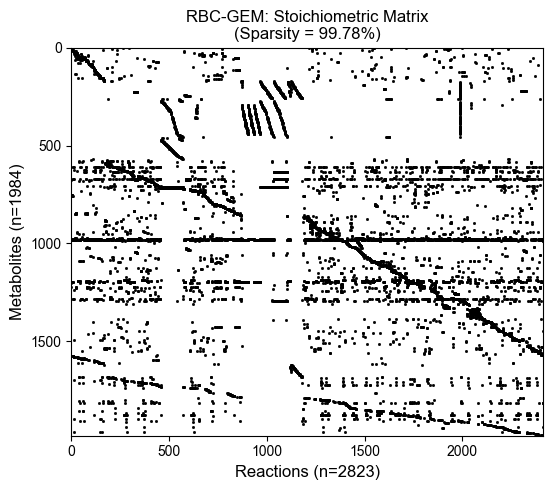

In [6]:
# Ratio of reactions to metabolites currently ~1.4 to 1
print(
    f"Reactions:metabolites ({len(model.reactions) / len(model.metabolites):.2f} : {len(model.metabolites) / len(model.metabolites):.2f})"
)

fig, ax = plt.subplots(1, 1, figsize=(1.4 * 4 + 1, 4 + 1))
S = create_stoichiometric_matrix(model, array_type="DataFrame")
if not include_boundary_in_calculations:
    S = S.loc[:, model.reactions.query(lambda x: not x.boundary).list_attr("id")]
sparsity = 1.0 - (np.count_nonzero(S) / float(S.size))

ax.spy(S, markersize=1, color="black")
ax.set_title(
    f"{model.id.replace('_', '-')}: Stoichiometric Matrix\n(Sparsity = {sparsity*100:.2f}%)",
    fontsize=12,
)
ax.set_xlabel(f"Reactions (n={len(model.reactions)})", fontsize=12)
ax.set_ylabel(f"Metabolites (n={len(model.metabolites)})", fontsize=12)
ax.xaxis.set_ticks_position("bottom")
metabolite_indicies = dict(
    zip(
        list(range(1 + len(model.metabolites.list_attr("id")) + 2)),
        model.metabolites.list_attr("id"),
    )
)
metabolite_indicies = pd.DataFrame.from_dict(
    dict(
        zip(
            list(range(1 + len(model.metabolites.list_attr("id")) + 2)),
            model.metabolites.list_attr("id"),
        )
    ),
    orient="index",
    columns=["metabolites"],
)


reaction_indicies = dict(
    zip(
        list(range(1 + len(model.reactions.list_attr("id")) + 2)),
        model.reactions.list_attr("id"),
    )
)
reaction_indicies = pd.DataFrame.from_dict(
    dict(
        zip(
            list(range(1 + len(model.reactions.list_attr("id")) + 2)),
            model.reactions.list_attr("id"),
        )
    ),
    orient="index",
    columns=["reactions"],
)
fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/network/MatrixSparsity.{imagetype}",
        transparent=transparent,
    )

### Calculate connectivities

In [7]:
def compute_connectivities(model, attribute_type="metabolites", compartments=None, exclude=None, sum_compartments=False, aggregate_ranking=False, include_boundary=False):
    """Compute the metabolite connectivities of the model.
    
    Parameters
    ----------
    model : Model
        The model object
    attribute_type : {"metabolites", "genes"}
        The type of object.
    compartments : list, None
        Compartments that should be accounted for. If ``None``, all metabolite compartments are utilized.
    exclude : iterable
        Contains identifiers for metabolites that should be excluded from calculations.
        Useful for excluding currency metabolites (e.g., hydrogen, water) from calculations.
    sum_compartments : bool
        Whether to treat the metabolite as one entity and sum metabolite connectivities across compartments. 
        If True, the connectivity is determined without regard to the species compartment.
        If False, the connectivity is determined seperately for species in different compartments.
    aggregate_ranking : bool
        If True, metabolites that have the same connectivity value are grouped together.
        If False, metabolites are kept seperately.
    include_boundary : bool
        If True, pseudoreactions are included in the connectivity count.
        If False, metabolites are kept seperately.
    """
    if not include_boundary:
        # Copy model and remove boundaries
        model = model.copy()
        model.remove_groups([model.groups.get_by_id("Pseudoreactions")])
        model.remove_reactions(model.boundary)
    species = getattr(model, attribute_type)
    # Get compartments
    if compartments:
        compartments = ensure_iterable(compartments)
    else:
        compartments = sorted(model.compartments)
    
    # Exclude metabolites
    if exclude is None:
        exclude = set()
    else:
        exclude = set([str(x) for x in ensure_iterable(exclude)])

    if attribute_type == "metabolites":
        species = species.query(
            lambda x: (not x.id.replace(f"_{x.compartment}", "") in exclude and not x.id in exclude )
            if sum_compartments else (not x.id in exclude)
        )
        species = species.query(lambda x: x.compartment in set(compartments))
    else:
        species = species.query(lambda x: not x.id in exclude)

    


    # Compute absolute connectivities
    absolute_connectivities = defaultdict(lambda: 0)
    absolute_connectivities = pd.Series({
        specie.id: len(specie.reactions) for specie in species
    }, name="absolute").sort_values(ascending=False)
    absolute_connectivities.index.name = attribute_type

    if sum_compartments and attribute_type == "metabolites":
        # Aggregate metabolites across compartments and sum
        absolute_connectivities = absolute_connectivities.rename({
            sid: sid.replace(f"_{species.get_by_id(sid).compartment}", "")
            for sid in absolute_connectivities.index
        }, axis=0)
        absolute_connectivities = absolute_connectivities.groupby(absolute_connectivities.index).sum()

    # Compute relative connectivities
    relative_connectivities = absolute_connectivities / absolute_connectivities.sum()
    relative_connectivities.name = "relative"
    # Create DataFrame
    df_connectivity = pd.merge(
        absolute_connectivities,
        relative_connectivities,
        left_index=True, 
        right_index=True
    )
    df_connectivity = df_connectivity.reset_index(drop=False)
    df_connectivity = df_connectivity.sort_values(["absolute", attribute_type], ascending=False)

    if aggregate_ranking:
        # Aggregate metabolites that share the same ranking
        df_connectivity = df_connectivity.groupby(["absolute", "relative"], as_index=False).agg(lambda x: set(x)).sort_index(ascending=False)
    # Reset index, reorganize columns, and return
    df_connectivity = df_connectivity.reset_index(drop=True).loc[:, [attribute_type, "absolute", "relative"]]
    return df_connectivity

#### Metabolite connectivity

In [8]:
num_display = 15
sum_compartments = True
aggregate_ranking = False
scale_points = False

attribute_type = "metabolites"

compartments = ["e"]
df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=[],
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
# table_data[attribute_type] = df_connectivity
df_connectivity = df_connectivity.set_index("metabolites")
df_connectivity.columns = pd.MultiIndex.from_product(
    [[model.compartments["e"]], df_connectivity.columns]
)
df_connectivity_e = df_connectivity.copy()


compartments = ["c"]
df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=[],
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
# table_data[attribute_type] = df_connectivity
df_connectivity = df_connectivity.set_index("metabolites")
df_connectivity.columns = pd.MultiIndex.from_product(
    [[model.compartments["c"]], df_connectivity.columns]
)
df_connectivity_c = df_connectivity.copy()

df_metabolite_connectivity_table = pd.merge(
    df_connectivity_c, df_connectivity_e, left_index=True, right_index=True, how="outer"
)

compartments = None
df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=[],
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
# table_data[attribute_type] = df_connectivity
df_connectivity = df_connectivity.set_index("metabolites")
df_connectivity.columns = pd.MultiIndex.from_product(
    [["total"], df_connectivity.columns]
)
df_connectivity_all = df_connectivity.copy()

df_metabolite_connectivity_table = (
    pd.merge(
        df_connectivity_all,
        df_metabolite_connectivity_table,
        left_index=True,
        right_index=True,
        how="outer",
    )
    .fillna(0)
    .sort_values(by=("total", "absolute"), ascending=False)
)
for col in df_metabolite_connectivity_table.columns:
    if col[1] == "absolute":
        df_metabolite_connectivity_table[col] = df_metabolite_connectivity_table[
            col
        ].astype(int)
    else:
        df_metabolite_connectivity_table[col] = df_metabolite_connectivity_table[
            col
        ].astype(float)
table_data[attribute_type] = df_metabolite_connectivity_table.copy()
df_metabolite_connectivity_table.head(num_display)

total            cytosol           extracellular space  \
            absolute  relative absolute  relative            absolute   
metabolites                                                             
h                964  0.090866      914  0.097421                  50   
h2o              739  0.069658      725  0.077276                  14   
na1              316  0.029786      158  0.016841                 158   
atp              283  0.026675      281  0.029951                   2   
coa              275  0.025921      275  0.029311                   0   
pi               216  0.020360      207  0.022064                   9   
nadp             204  0.019229      202  0.021531                   2   
nadph            203  0.019135      203  0.021637                   0   
adp              178  0.016778      176  0.018759                   2   
ppi              138  0.013008      137  0.014602                   1   
amp              124  0.011688      122  0.013004                   2   
crn              115  0.010840      114  0.012151                   1   
nad              114  0.010746      111  0.011831                   3   
nadh             109  0.010274      109  0.011618                   0   
o2               103  0.009709      102  0.010872                   1   

                       
             relative  
metabolites            
h            0.040750  
h2o          0.011410  
na1          0.128769  
atp          0.001630  
coa          0.000000  
pi           0.007335  
nadp         0.001630  
nadph        0.000000  
adp          0.001630  
ppi          0.000815  
amp          0.001630  
crn          0.000815  
nad          0.002445  
nadh         0.000000  
o2           0.000815

In [9]:
df_metabolite_connectivity_table

total            cytosol            \
                       absolute  relative absolute  relative   
metabolites                                                    
h                           964  0.090866      914  0.097421   
h2o                         739  0.069658      725  0.077276   
na1                         316  0.029786      158  0.016841   
atp                         283  0.026675      281  0.029951   
coa                         275  0.025921      275  0.029311   
...                         ...       ...      ...       ...   
FAcrn_hs_18_7Z                1  0.000094        1  0.000107   
mi134p                        1  0.000094        1  0.000107   
FAcrn_hs_18_6Z9Z12Z15Z        1  0.000094        1  0.000107   
FAcrn_hs_18_6Z9Z12Z           1  0.000094        1  0.000107   
zymstnl                       1  0.000094        1  0.000107   

                       extracellular space            
                                  absolute  relative  
metabolites                                           
h                                       50  0.040750  
h2o                                     14  0.011410  
na1                                    158  0.128769  
atp                                      2  0.001630  
coa                                      0  0.000000  
...                                    ...       ...  
FAcrn_hs_18_7Z                           0  0.000000  
mi134p                                   0  0.000000  
FAcrn_hs_18_6Z9Z12Z15Z                   0  0.000000  
FAcrn_hs_18_6Z9Z12Z                      0  0.000000  
zymstnl                                  0  0.000000  

[1577 rows x 6 columns]

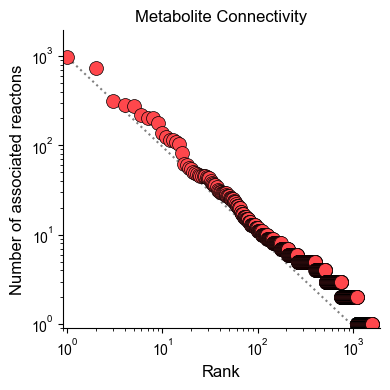

In [10]:
df_connectivity = df_metabolite_connectivity_table["total"].reset_index(drop=False)

fontsize = 12

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.despine(fig)

key = "absolute"
ax.scatter(
    df_connectivity[key].index + 1,  # Log plots do not do well with index of 0.
    df_connectivity[key].values,
    marker="o",
    edgecolors="black",
    lw=0.5,
    # linestyle="",
    color="xkcd:light red",
    s=df_connectivity["relative"].values * 10000 if scale_points else 100,
    zorder=2,
)
ax.set_xscale("log")
ax.set_yscale("log")
# A reference line, linking the minimum and maximum connectivities
ax.loglog(
    [df_connectivity[key].max(), df_connectivity[key].min()],
    [df_connectivity[key].min(), df_connectivity[key].max()],
    zorder=1,
    color="grey",
    linestyle=":",
)
ax.set_title(f"Metabolite Connectivity", fontdict={"size": fontsize})
ax.set_xlabel("Rank", fontdict={"size": fontsize})
ax.set_ylabel("Number of associated reactons", fontdict={"size": fontsize})
ax.set_xlim(
    (0.9, df_connectivity[key].max() * 2)
)  # Add some padding for figure clarity
ax.set_ylim(
    (0.9, df_connectivity[key].max() * 2)
)  # Add some padding for figure clarity
fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/network/{attribute_type}_Connectivity.{imagetype}",
        transparent=transparent,
    )

### Gene connectivity

In [11]:
num_display = 15
compartments = None
sum_compartments = True
aggregate_ranking = False
scale_points = False

attribute_type = "genes"

df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=[],
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
table_data[attribute_type] = df_connectivity.copy()
df_connectivity.iloc[num_display : num_display * 2].head(num_display)

,genes,absolute,relative
15,ACOT7,41,0.010513
16,FASN,38,0.009744
17,MBLAC2,37,0.009487
18,ABCC4,37,0.009487
19,HSD17B12,33,0.008462
20,TECR,31,0.007949
21,HACD3,31,0.007949
22,GPX1,31,0.007949
23,HBZ,29,0.007436
24,HBM,29,0.007436


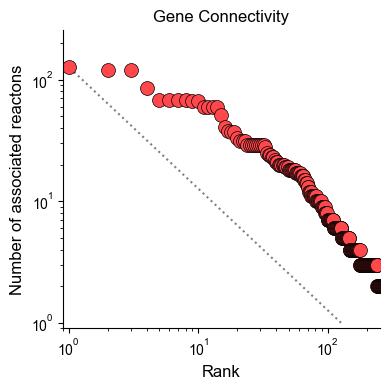

In [12]:
fontsize = 12

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.despine(fig)

key = "absolute"
ax.scatter(
    df_connectivity[key].index + 1,  # Log plots do not do well with index of 0.
    df_connectivity[key].values,
    marker="o",
    edgecolors="black",
    lw=0.5,
    # linestyle="",
    color="xkcd:light red",
    s=df_connectivity["relative"].values * 10000 if scale_points else 100,
    zorder=2,
)
ax.set_xscale("log")
ax.set_yscale("log")
# A reference line, linking the minimum and maximum connectivities
ax.loglog(
    [df_connectivity[key].max(), df_connectivity[key].min()],
    [df_connectivity[key].min(), df_connectivity[key].max()],
    zorder=1,
    color="grey",
    linestyle=":",
)
ax.set_title(f"Gene Connectivity", fontdict={"size": fontsize})
ax.set_xlabel("Rank", fontdict={"size": fontsize})
ax.set_ylabel("Number of associated reactons", fontdict={"size": fontsize})
ax.set_xlim(
    (0.9, df_connectivity[key].max() * 2)
)  # Add some padding for figure clarity
ax.set_ylim(
    (0.9, df_connectivity[key].max() * 2)
)  # Add some padding for figure clarity
fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/network/{attribute_type}_Connectivity.{imagetype}",
        transparent=transparent,
    )

In [13]:
print(list(table_data.keys()))
if save_figures:
    with pd.ExcelWriter(
        f"{ROOT_PATH}{RESULTS_PATH}/network/ModelConnectivity.xlsx"
    ) as writer:
        for sheet_name, df in table_data.items():
            df.to_excel(writer, sheet_name=sheet_name, index=True)

['metabolites', 'genes']


### Visualize global interaction network

In [14]:
df_network_edges = pd.read_csv(
    f"{ROOT_PATH}{DATABASE_PATH}/NetworkEdges_{GEM_NAME}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)
df_network_node_aliases = pd.read_csv(
    f"{ROOT_PATH}{DATABASE_PATH}/NetworkNodes_{GEM_NAME}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)

all_edge_node_ids = set(df_network_edges["node_A"]).union(df_network_edges["node_B"])
df_isolated = (
    df_network_node_aliases[~df_network_node_aliases["node_id"].isin(all_edge_node_ids)]
    .loc[:, ["node_id", "node_type"]]
    .drop_duplicates()
)
df_network_nodes = (
    df_network_node_aliases[df_network_node_aliases["node_id"].isin(all_edge_node_ids)]
    .loc[:, ["node_id", "node_type"]]
    .drop_duplicates()
)
df_edge_summary = df_network_edges.set_index(["node_A", "node_B"])[
    ["edge_type"]
].value_counts()
df_edge_summary.index = list(map(itemgetter(0), df_edge_summary.index))

df_node_summary = df_network_nodes.set_index(["node_id"])[["node_type"]].value_counts()
df_node_summary.index = list(map(itemgetter(0), df_node_summary.index))

df_isolated_summary = df_isolated.set_index(["node_id"]).value_counts()
df_isolated_summary.index = list(map(itemgetter(0), df_isolated_summary.index))

print(df_edge_summary, f"\n\nTotal number of edges:\t {df_edge_summary.sum()}\n")
print(df_node_summary, f"\n\nTotal number of nodes:\t {df_node_summary.sum()}\n")
print(
    df_isolated_summary,
    f"\n\nTotal number of isolated nodes:\t {df_isolated_summary.sum()}\n",
)

drug-drug                         216799
reaction-metabolite                10489
gene/protein-snp                    4439
gene/protein-reaction               3900
drug-gene/protein                   3771
gene/protein-phenotype/disease       531
drug-snp                              14
Name: count, dtype: int64 

Total number of edges:	 239943

snp                  4439
reaction             2412
drug                 2083
metabolite           1984
gene/protein          693
phenotype/disease     514
Name: count, dtype: int64 

Total number of nodes:	 12125

snp    3
Name: count, dtype: int64 

Total number of isolated nodes:	 3



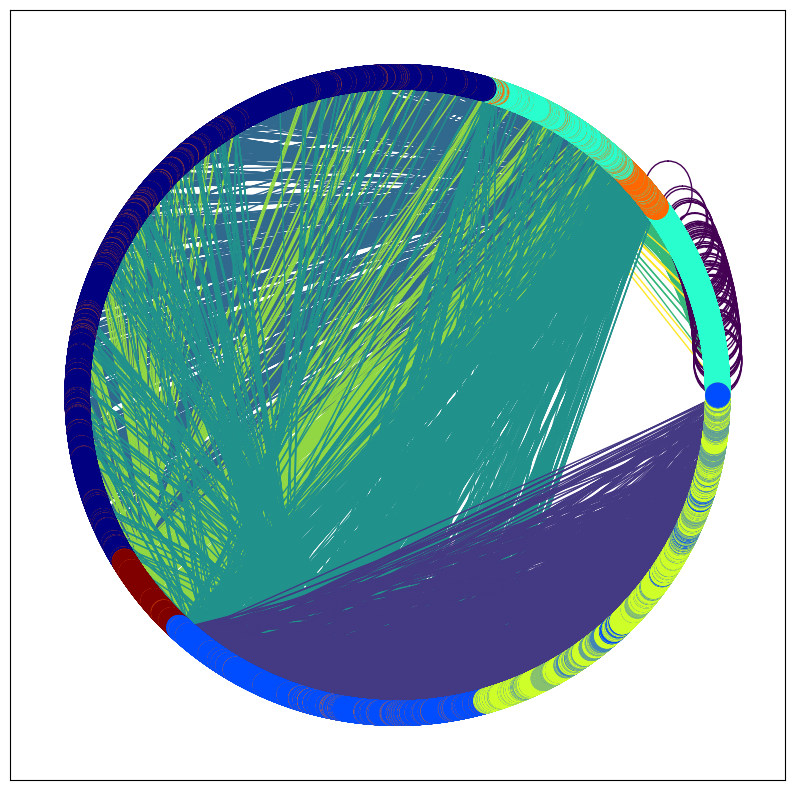

In [15]:
df_nodes = df_network_nodes.copy()
df_edges = df_network_edges.copy()


cmap = mpl.colormaps["jet"].resampled(len(df_node_summary.index))
node_colors_dict = {
    node_type: cmap(idx) for idx, node_type in enumerate(df_node_summary.index)
}

cmap = mpl.colormaps["viridis"].resampled(len(df_edge_summary.index))
edge_colors_dict = {
    node_type: cmap(idx) for idx, node_type in enumerate(df_edge_summary.index)
}


df_nodes["color"] = df_nodes["node_type"].apply(lambda x: node_colors_dict[x])
df_edges["color"] = df_edges["edge_type"].apply(lambda x: edge_colors_dict[x])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx_graph = nx.from_pandas_edgelist(
    df=df_edges,
    source="node_A",
    target="node_B",
    create_using=nx.Graph,
    edge_attr=True,
)
nx_graph.add_nodes_from(
    (n, dict(d))
    for n, d in df_nodes.set_index("node_id").iterrows()
    if n in nx_graph.nodes
)

node_colors = [attr_dict["color"] for (node_id, attr_dict) in nx_graph.nodes(data=True)]
edge_colors = [attr_dict["color"] for (x, y, attr_dict) in nx_graph.edges(data=True)]

pos = nx.circular_layout(nx_graph, scale=1, center=None, dim=2)
nx.draw_networkx_nodes(
    nx_graph,
    pos,
    ax=ax,
    # nodelist=None,
    # node_size=300,
    node_color=node_colors,
    # node_shape='o',
    # alpha=None,
    # cmap=None,
    # vmin=None,
    # vmax=None,
    # linewidths=None,
    # edgecolors=None,
    # label=None,
    # margins=None,
)
nx.draw_networkx_edges(
    nx_graph,
    pos,
    ax=ax,
    # edgelist=None,
    # width=1.0,
    edge_color=edge_colors,
    # style='solid',
    # alpha=None,
    # arrowstyle=None,
    # arrowsize=10,
    # edge_cmap=None,
    # edge_vmin=None,
    # edge_vmax=None,
    # arrows=None,
    # label=None,
    # node_size=300,
    # nodelist=None,
    # node_shape='o',
    # connectionstyle='arc3',
    # min_source_margin=0,
    # min_target_margin=0,
)
fig;